In [1]:
import os
import codecs
import math
import lightgbm
import sklearn.metrics
import sklearn
import numpy as np
import mnist_loader2

from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train, X_val, y_val, X_test, y_test ) =  mnist_loader2.load_mnist()
X_mean = np.mean(X_train,axis=0)
X_train= X_train - X_mean
X_val= X_val - X_mean
X_test = X_test - X_mean
cov = np.dot(X_train.T, X_train)/ X_train.shape[0] # get the data covariance matrix
U,S,V = np.linalg.svd(cov) #Columns of U = eigenvectors, S = eigenvalues

In [3]:
num_pc = [1,5,7,10,25,50,100]

In [4]:
lgb_params = dict()
lgb_params['boosting_type'] = 'gbdt'  # space['boosting_type'], # 'gbdt', # gbdt | dart | goss
# px['objective'] ='multi:softprob'
lgb_params['application'] = 'multiclass'
lgb_params['metric'] = 'multi_logloss'
lgb_params['num_class'] = 10
lgb_params['learning_rate'] = 0.05
lgb_params['num_leaves'] = 100
lgb_params['min_data_in_leaf'] = 100
lgb_params['min_sum_hessian_in_leaf'] = 1e-3
lgb_params['max_depth'] = -1
lgb_params['lambda_l1'] = 0.0  # space['lambda_l1'],
lgb_params['lambda_l2'] = 0.0  # space['lambda_l2'],
lgb_params['max_bin'] = 256
lgb_params['feature_fraction'] = 0.7
lgb_params['bagging_fraction'] = 0.7
lgb_params['bagging_freq'] = 1


In [5]:
num_ds =-1
accs = []
for pc in num_pc:
    print('Number of Principal Components: ', pc)
    X_tr = np.dot(X_train, U[:,:pc])
    X_va = np.dot(X_val, U[:,:pc])
    X_te = np.dot(X_test, U[:,:pc])
    
    D_train = lightgbm.Dataset(X_tr[:num_ds], y_train[:num_ds])
    D_val = lightgbm.Dataset(X_va[:num_ds], y_val[:num_ds])
    
    model = lightgbm.train(lgb_params,
                       D_train,
                       num_boost_round=1000,
                       valid_sets=D_val,
                       early_stopping_rounds=100,
                       verbose_eval=100)
    nb_trees = model.best_iteration
    
    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict(X_te, num_iteration=nb_trees )
    test_loss = sklearn.metrics.log_loss( y_test, y_pred, labels=list(range(10)))
    
    acc = sklearn.metrics.accuracy_score( y_test, np.argmax( y_pred, axis=1 ) )

    print('test_loss={} test_acc={}'.format(test_loss, acc))
    accs.append(acc)
np.save('lgbm_acc.py',accs)

('Number of Principal Components: ', 1)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 1.84816
[200]	valid_0's multi_logloss: 1.84835
Early stopping, best iteration is:
[138]	valid_0's multi_logloss: 1.84607
nb_trees=138
test_loss=1.82078085065 test_acc=0.2983
('Number of Principal Components: ', 5)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.772612
[200]	valid_0's multi_logloss: 0.678222
[300]	valid_0's multi_logloss: 0.667599
[400]	valid_0's multi_logloss: 0.675187
Early stopping, best iteration is:
[304]	valid_0's multi_logloss: 0.667395
nb_trees=304
test_loss=0.653816729699 test_acc=0.754
('Number of Principal Components: ', 7)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.505554
[200]	valid_0's multi_logloss: 0.391886
[300]	valid_0's multi_logloss: 0.371098
[400]	valid_0's multi_logloss: 0.371112
Early stopping, best iteration is:
[34

In [6]:
num_ds =-1
svm_accs = []
for pc in num_pc:
    print('Number of Principal Components: ', pc)
    X_tr = np.dot(X_train, U[:,:pc])
    X_va = np.dot(X_val, U[:,:pc])
    X_te = np.dot(X_test, U[:,:pc])
    print(X_tr[:num_ds].shape)
    classifier = svm.SVC(C=1e-6,kernel='linear', cache_size= 1536, probability=False)
    classifier.fit(X_tr[:num_ds], y_train[:num_ds])
    print('Predicting Test')
    y_pred = classifier.predict(X_te)

    acc = accuracy_score( y_test, y_pred )
    print('test_acc={}'.format( acc))
    svm_accs.append(acc)
np.save('svm_acc.py',svm_accs)

('Number of Principal Components: ', 1)
(47999, 1)
Predicting Test
test_acc=0.3115
('Number of Principal Components: ', 5)
(47999, 5)
Predicting Test
test_acc=0.7124
('Number of Principal Components: ', 7)
(47999, 7)
Predicting Test
test_acc=0.7993
('Number of Principal Components: ', 10)
(47999, 10)
Predicting Test
test_acc=0.8419
('Number of Principal Components: ', 25)
(47999, 25)
Predicting Test
test_acc=0.919
('Number of Principal Components: ', 50)
(47999, 50)
Predicting Test
test_acc=0.9374
('Number of Principal Components: ', 100)
(47999, 100)
Predicting Test
test_acc=0.9436


[1, 5, 7, 10, 25, 50, 100]


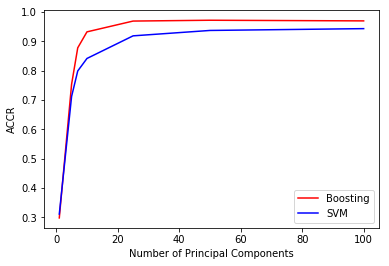

In [7]:
lgbm_accs = np.load('lgbm_accs.npy')
svm_accs = np.load('svm_accs.npy')
import matplotlib.pyplot as plt
print(num_pc)
plt.plot(num_pc,lgbm_accs,'r',label = 'Boosting')
plt.plot(num_pc,svm_accs,'b',label = 'SVM')
plt.legend(loc = 'lower right')
plt.xlabel('Number of Principal Components')
plt.ylabel('ACCR')
plt.show()

In [8]:
#best ACCR: 97.22 (Gradient Boosting Decision Trees)